# Transformer: DistilBERT fine-tuning (SMS Spam)

Cel:
- fine-tuning DistilBERT do klasyfikacji spam vs ham
- ewaluacja: accuracy, precision/recall/F1 (spam), macro F1
- confusion matrix

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
set_seed(RANDOM_STATE)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


'cpu'

In [2]:
REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_path = REPO_ROOT / "data" / "processed" / "sms_spam_clean.csv"
assert data_path.exists(), f"Brak pliku: {data_path}"

df = pd.read_csv(data_path)

X = df["text_clean"].astype(str).values
y = df["label_bin"].astype(int).values  # 1=spam, 0=ham

# najpierw test 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# walidacja 20% z train
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(len(X_train), len(X_val), len(X_test))
print("spam% train/val/test:", y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))

3565 892 1115
spam% train/val/test: 0.1341 0.1345 0.1336


In [3]:
train_ds = Dataset.from_dict({"text": X_train, "label": y_train})
val_ds   = Dataset.from_dict({"text": X_val,   "label": y_val})
test_ds  = Dataset.from_dict({"text": X_test,  "label": y_test})

train_ds[0]

{'text': "that sucks. so what do you got planned for your yo valentine? i am your yo valentine aren't i?",
 'label': 0}

In [4]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_tok = train_tok.remove_columns(["text"])
val_tok   = val_tok.remove_columns(["text"])
test_tok  = test_tok.remove_columns(["text"])

train_tok

Map: 100%|██████████| 1115/1115 [00:00<00:00, 75084.67 examples/s]


Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 3565
})

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)

    # dla spamu jako klasy pozytywnej (1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", pos_label=1, zero_division=0)
    macro_f1 = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)[2]

    return {
        "accuracy": acc,
        "precision_spam": prec,
        "recall_spam": rec,
        "f1_spam": f1,
        "macro_f1": macro_f1,
    }

In [7]:
out_dir = REPO_ROOT / "models" / "distilbert_sms_spam"

training_args = TrainingArguments(
    output_dir=str(out_dir),
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/6d/kwj2bjld71v8wh7n3zyyzsbm0000gn/T/ipykernel_1647/65118615.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Spam,Recall Spam,F1 Spam,Macro F1
1,0.027500,0.060145,0.988789,0.974138,0.941667,0.957627,0.975584
2,0.012200,0.069821,0.980942,0.905512,0.958333,0.931174,0.960057
3,0.005600,0.056430,0.987668,0.965812,0.941667,0.953586,0.973238


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=669, training_loss=0.03777969097342727, metrics={'train_runtime': 122.306, 'train_samples_per_second': 87.445, 'train_steps_per_second': 5.47, 'total_flos': 172800099391320.0, 'train_loss': 0.03777969097342727, 'epoch': 3.0})

In [8]:
test_metrics = trainer.evaluate(test_tok)
test_metrics

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.04442279785871506,
 'eval_accuracy': 0.9919282511210762,
 'eval_precision_spam': 0.9794520547945206,
 'eval_recall_spam': 0.959731543624161,
 'eval_f1_spam': 0.9694915254237289,
 'eval_macro_f1': 0.9824201813165157,
 'eval_runtime': 3.9464,
 'eval_samples_per_second': 282.533,
 'eval_steps_per_second': 8.869,
 'epoch': 3.0}

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

      ham(0)       0.99      1.00      1.00       966
     spam(1)       0.98      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



<Figure size 640x480 with 0 Axes>

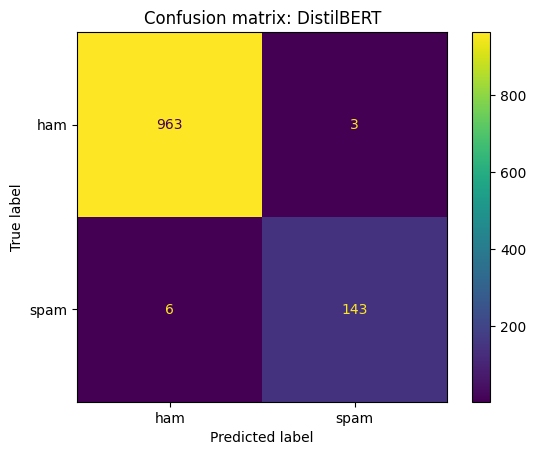

In [9]:
pred = trainer.predict(test_tok)
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=-1)

print(classification_report(y_true, y_pred, target_names=["ham(0)", "spam(1)"], zero_division=0))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["ham", "spam"])
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion matrix: DistilBERT")
plt.show()

In [10]:
reports_dir = REPO_ROOT / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

row = {
    "model": "DistilBERT (fine-tuned)",
    "accuracy": test_metrics["eval_accuracy"],
    "precision_spam": test_metrics["eval_precision_spam"],
    "recall_spam": test_metrics["eval_recall_spam"],
    "f1_spam": test_metrics["eval_f1_spam"],
    "macro_f1": test_metrics["eval_macro_f1"],
}

out_path = reports_dir / "transformer_results.csv"
pd.DataFrame([row]).to_csv(out_path, index=False)
out_path

PosixPath('/Users/konrad/Documents/-ZUM_2025_KonradObrebski/reports/transformer_results.csv')